In [11]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

In [12]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = '\t')
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

### Load Dataset

In [13]:
root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

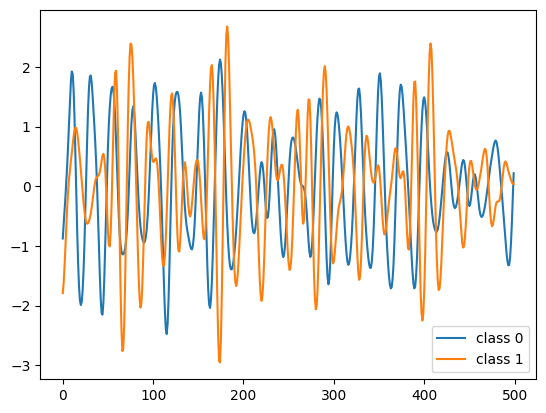

In [14]:
# Visualize the data
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

### Build Model

In [19]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Args:
        inputs (numpy.ndarray): tensor to be processed.
        head_size (int): hidden size per attention head.
        num_heads (int): number of attention heads.
        ff_dim (int): size of the feedforward layer.
        dropout (float): dropout rate.
    """
    # Normalization and attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed-forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [20]:
def build_conv1_model(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    gap = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(n_classes, activation="softmax")(gap)
    return keras.Model(inputs, outputs)

In [15]:
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=10,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

### Train and evaluate

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 500, 1)]             0         []                            
                                                                                                  
 layer_normalization_6 (Lay  (None, 500, 1)               2         ['input_4[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_3 (Mu  (None, 500, 1)               7169      ['layer_normalization_6[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_6[0][0]
                                                                    ']                      

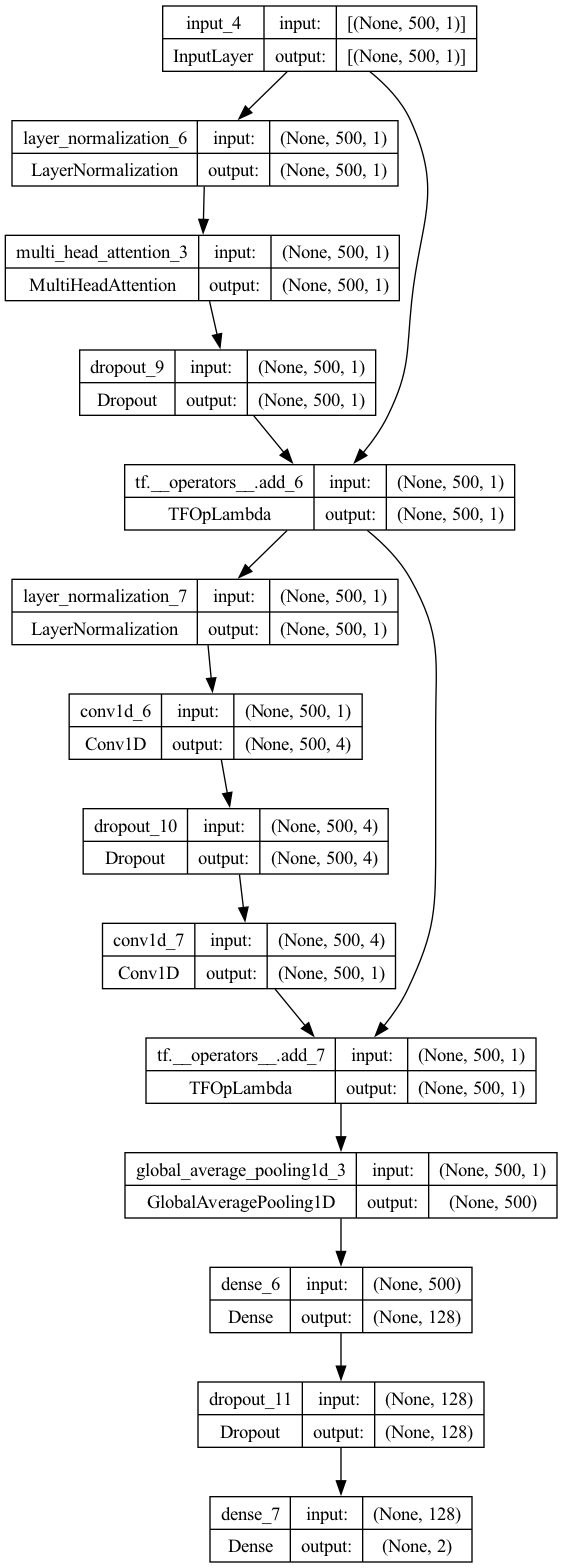

In [21]:
input_shape = x_train.shape[1:]

model = build_transformer_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    n_classes=n_classes,
)

# model = build_conv1_model(input_shape, n_classes)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [22]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [23]:
model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
45/45 [==============================] - 58s 1s/step - loss: 0.9621 - sparse_categorical_accuracy: 0.5156 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.5770
Epoch 2/200
45/45 [==============================] - 56s 1s/step - loss: 0.8305 - sparse_categorical_accuracy: 0.5681 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6311
Epoch 3/200
45/45 [==============================] - 56s 1s/step - loss: 0.7637 - sparse_categorical_accuracy: 0.5875 - val_loss: 0.6160 - val_sparse_categorical_accuracy: 0.6630
Epoch 4/200
45/45 [==============================] - 58s 1s/step - loss: 0.7521 - sparse_categorical_accuracy: 0.6059 - val_loss: 0.5975 - val_sparse_categorical_accuracy: 0.6713
Epoch 5/200
45/45 [==============================] - 56s 1s/step - loss: 0.6796 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.5848 - val_sparse_categorical_accuracy: 0.6935
Epoch 6/200
45/45 [==============================] - 55s 1s/step - loss: 0.6734 - sparse_categorical_accu